In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
data = pd.read_csv("../../dataset/cleaned_bank.csv", delimiter=',')

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Separate features (X) and target (y)
X = data.copy()
y = X.pop("y")  # Target feature

# Label encoding for categorical variables
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_baseline = model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold the feature importances and sort them
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display the feature importance values
print(importance_df)


Accuracy: 0.9604989604989606
              precision    recall  f1-score   support

          no       0.96      1.00      0.98       461
         yes       1.00      0.05      0.10        20

    accuracy                           0.96       481
   macro avg       0.98      0.53      0.54       481
weighted avg       0.96      0.96      0.94       481

      Feature  Importance
11   duration    0.198325
5     balance    0.154515
10      month    0.152965
0         age    0.141110
9         day    0.114369
1         job    0.063470
12   campaign    0.048908
8     contact    0.032119
3   education    0.030567
2     marital    0.025491
6     housing    0.022633
7        loan    0.008951
4     default    0.006577
13      pdays    0.000000
14   previous    0.000000
15   poutcome    0.000000


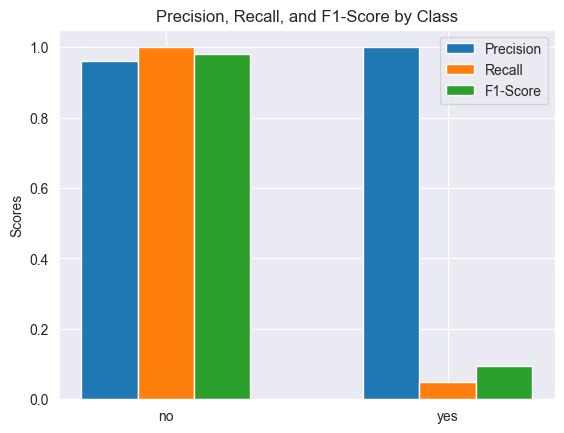

In [19]:
import numpy as np

# Classification report data
metrics = classification_report(y_test, y_pred_baseline, output_dict=True)

# Extract metrics for each class
precision = [metrics['no']['precision'], metrics['yes']['precision']]
recall = [metrics['no']['recall'], metrics['yes']['recall']]
f1_score = [metrics['no']['f1-score'], metrics['yes']['f1-score']]

# Class labels
labels = ['no', 'yes']

# Plot bar chart
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-Score')

# Add some labels
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


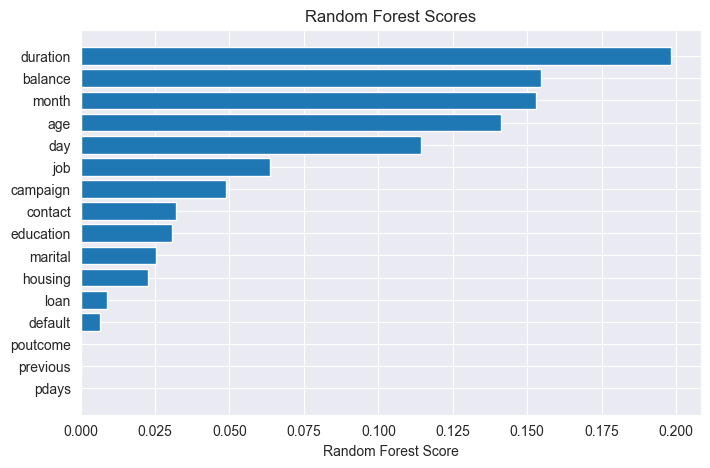

In [11]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Random Forest Scores")
    plt.xlabel("Random Forest Score")  

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(importance_df.set_index('Feature')['Importance'])
plt.show()  

**RandomizedSearchCV for Hyperparameter Tuning**


In [12]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],   # Number of trees
    'max_depth': [10, 20, 30, None],              # Maximum depth of trees
    'min_samples_split': [2, 5, 10],              # Minimum samples required to split an                                                     internal node
    'min_samples_leaf': [1, 2, 4],                # Minimum samples required in a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],     # Number of features to consider when                                                         looking for the best split
    'bootstrap': [True, False]                    # Whether to use bootstrap samples when                                                    building trees
}

rf_model = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
rf_random.fit(X, y)

print(f"Best parameters found: {rf_random.best_params_}")

best_model = rf_random.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\adein\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
117 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\adein\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adein\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\adein\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base

Best parameters found: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


Key Arguments:
**n_iter=100:** This defines how many different combinations to try. RandomizedSearchCV will randomly sample 100 combinations of hyperparameters from the **param_grid**.
**cv=5:** This specifies that 5-fold cross-validation should be used for evaluation.
**verbose=2:** This controls the amount of logging, so you can monitor the progress.
**n_jobs=-1:** This allows the process to run in parallel on all available CPU cores, making it faster.
**Summary**
We have found a set of hyperparameters that should give the best performance based on cross-validation.
The model uses 500 trees, grows them without limiting depth (None), and uses log2 features at each split.
The min_samples_leaf is set to 4, meaning each leaf must have at least 4 samples, which helps to generalize the model better.
Bootstrap sampling is used to build the trees, helping reduce overfitting.

In [13]:
# Re-initialize the Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(n_estimators=500, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       max_features='log2', 
                                       max_depth=None, 
                                       bootstrap=True, 
                                       random_state=42)

# Train the model
best_rf_model.fit(X, y)

# Evaluate the model
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_rf_model, X, y, cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")


Cross-validation scores: [0.95426195 0.95218295 0.95218295 0.95416667 0.95416667]
Mean accuracy: 0.9534


These are the accuracy scores from each fold during the cross-validation process:

The model performed with 95.43% accuracy on the first fold.
In the second and third folds, the model achieved 95.22% accuracy.
For the fourth and fifth folds, the accuracy was 95.42%.
The results show that the model performs consistently across the different folds, with only minor variations in accuracy.
The mean accuracy across all the folds is 95.34%. This means that on average, the model correctly predicted the target variable for 95.34% of the data during cross-validation.

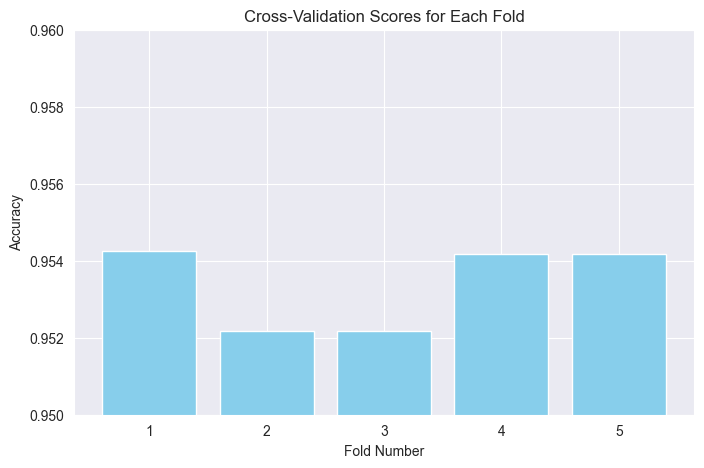

In [14]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue')
plt.title('Cross-Validation Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.95, 0.96)  # Set limits to zoom in on scores
plt.show()


A **learning curve** shows how model performance changes with different training set sizes, giving an idea of whether the model has enough data or if it’s overfitting.



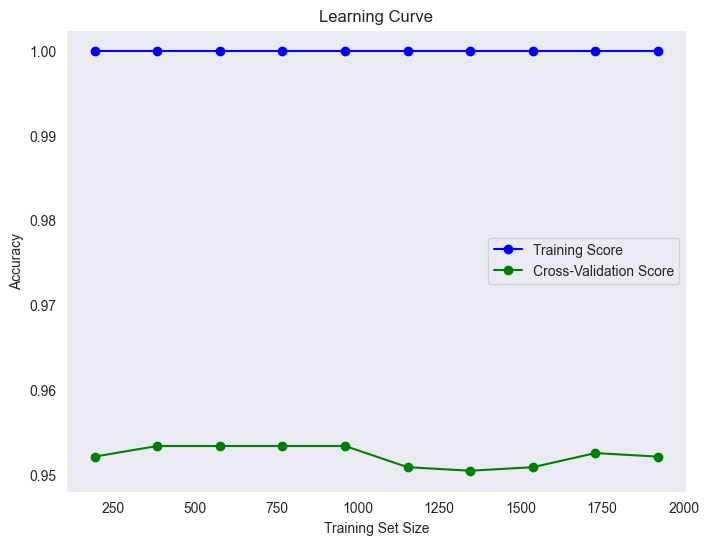

In [15]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(random_state=42), X, y, 
                                                        cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()


Overfitting: Since the training score is perfect (1.00) but the cross-validation score is lower (~0.95), it means the model is likely overfitting the training data, capturing noise and unnecessary complexity that doesn't generalize well to new data.
No Improvement with More Data: The cross-validation score doesn’t improve significantly as the training set size increases. This suggests that increasing the training data alone may not improve the model's performance further.